# Data visualisation

We start by importing the data and do analisys on it.

In [11]:
import sklearn
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels as sm

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation 
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

#sklearn → model trening
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import accuracy_score

#sklearn → data treatment
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# path definitions

ROOT = "../../"

DATA_PATH = ROOT + "data/"

DATA_INFO = DATA_PATH + "info/"
DATA_INFO_NIBIO_FILE = DATA_INFO  + "lmt.nibio.csv"
DATA_INFO_FROST_FILE = DATA_INFO + "Frost_stations.csv"
DATA_FILE_SOIL_STATIONS = DATA_INFO + "'Stasjonsliste jordtemperatur modellering.xlsx'"

DATA_COLLECTION = DATA_PATH + "raw_data/"
DATA_COLLECTION_STAT = DATA_COLLECTION + "Veret paa Aas 2013- 2017/" # pattern -> 'Veret paa Aas 2013- 2017/Veret paa Aas {YYYY}.pdf'
DATA_COLLECTION_TIME = DATA_COLLECTION + "Time 2013- 2023/" # pattern -> Time{YYYY}.xlsx
DATA_COLLECTION_NIBIO = DATA_COLLECTION + "nibio/" # pattern -> weather_data_hour_stID{id}_y{year}.csv

# ID definitions

station_names = pd.read_csv(DATA_INFO_NIBIO_FILE,
                          header=0,
                          index_col = "ID")

nibio_id = {
    "Innlandet" : [11,18,26,27],
    "Trøndelag" : [15,57,34,39],
    "Østfold" : [37,41,52,118],
    "Vestfold" : [30,38,42,50]
}

In [ ]:
# function definitions

import os.path

def table2Latex(table, dir_path, file_name, header = "", append = False):
    if os.path.isfile(dir_path + file_name + ".tex") & append:
        file = open(dir_path+filename+".tex","a", encoding="utf-8")
    else:
        file = open(dir_path+filename+".tex","w", encoding="utf-8")

    file.write(r"\begin{tabular}{|l|" + ["c" for _ in range(len(header))].join("|") + "|}")
    if header != "":
        file.write(header.join("&") + r"\\\hline")
    for row in table:
        file.write(row.join("&") + r"\\\hline")
    file.write(r"\end{tabular}")

"""
file_name.nibio = function(station_id, year, path = NULL){
    if(is.null(path)){
        pattern = DATA_COLLECTION_NIBIO + "weather_data_hour_stID" + station_id + "_y" + year + ".csv"
    } else {
        pattern = sprintf(path,station_id,year)
    }
    return(pattern)
}

data.nibio = function(station_id,year, path = NULL){
    path = file_name.nibio(station_id,year, path = path)
    data_nibio = read.csv(path,
                       header=T, col.names = c("Time","TM","RR","TJM10","TJM20"))
    data_nibio = mutate(data_nibio,across(
                                    "Time",
                                  str2date))
    data_nibio = column_to_rownames(data_nibio, var = "Time")
    data_nibio = mutate_at(data_nibio,c("TM","RR","TJM10","TJM20"), as.numeric)
    return(data_nibio)
}
na.interpol.cust = function(data, maxgap = Inf, n.p, 
                             s.window = 10, alg.option = "linear"){
    data.decomp = stlplus::stlplus(data,n.p = n.p, s.window = s.window)
    data.new = rep(0,length.out = length(data))
    for(part in c("seasonal", "trend", "remainder")){
        data.new = data.new + na_interpolation(data.decomp$data[,part],
                                                maxgap=maxgap,
                                                option = alg.option)
    }
    return(data.new)
}
str2date = function(x) {
    return(as.POSIXlt(x + "00",
                      format = "%Y-%m-%d %H:%M:%S%z",
                      tz="GMT"))
}

na.interplol.kal =function(data, maxgap = Inf, n.p, 
                             s.window = 10, alg.option = "StructTS"){
    data.decomp = stlplus::stlplus(data,n.p = n.p, s.window = s.window)
    data.new = rep(0,length.out = length(data))
    for(part in c("seasonal", "trend", "remainder")){
        data.new = data.new + na_kalman(data.decomp$data[,part],
                                                maxgap=maxgap,
                                                model = alg.option,
                                        smooth = TRUE)
    }
    return(data.new)
}

find.na.index.length = function(x){ # antar at x er bool vektor
    i = 1 # starting index
    na.data = data.frame()
    while(i <= length(x)){
        sample.data = x[i:length(x)]
        first = match(T, sample.data, nomatch = -1)
        if(first < 0) {
            break
        }
        last = match(F, sample.data[first:length(sample.data)], nomatch = length(sample.data[first:length(sample.data)])+1) - 2 + first

        na.data = rbind(na.data, data.frame(Length = c(last-first + 1), First = c(first+i-1), Last = c(last+i-1)))
        i = i + last
    }
    return(na.data)
}
"""

In [10]:
station_names

,Navn
ID,
10,Alvdal
11,Apelsvoll
12,Balestrand
145,Bjørkelangen
143,Brunlanes
...,...
118,Øsaker
53,Årnes
5,Ås


The data is splitted among two collections of data, one is a pdf and the other is a `.xlsx` format. We start by collecting the data from the hourly data collection.

In [12]:

def time_frost():
    """
        Frost API deliver a json format.
    """
    pass

def time_nibio():
    global nibio_id #! need to change later.

    # flattening dict

    nibio_id_flat = []

    for vals in nibio_id.values():
        nibio_id_flat += vals
    
    data_dict = {
        R : {
            S: {
                y: pd.DataFrame() for y in range(2014,2020+1)
            } for S in nibio_id[R]
        } for R in nibio_id
    } 
    for reg in nibio_id:
        for id in nibio_id[reg]:
            for year in range(2014,2020+1):
                data = pd.read_csv(DATA_COLLECTION_NIBIO + "weather_data_hour_stID{}_y{}.csv".format(id,year),
                                   delimiter = ",",
                                   header = 0,
                                   parse_dates = True,
                                   names = ["Time", "TM","RR","TJM10","TJM20"])
                data["Time"] = pd.to_datetime(data["Time"] + "00",
                                              format = "%Y-%m-%d %H:%M:%S%z",
                                              utc=True)
                data_dict[reg][id][year] = data

    return daily_2014_2020
        

def time_nmbu():
    hourly_data_2013_2023 = {
        i : pd.DataFrame() for i in range(2013,2024)
    }
    for i in range(2016,2024): # starts from 2016 rather than 2013 due to difference in data quality
        raw_data = pd.read_excel(DATA_COLLECTION_TIME + "Time{}.xlsx".format(i)) # fetching data
        raw_data["DATO"] = pd.to_datetime(raw_data["DATO"], format="%d%m%y %H")
        raw_data = raw_data.set_index("DATO") # setting the date as index
        if len(set(["JT10","JT20","LT","NB"]).intersection(raw_data.columns)) == 4:
            hourly_data_2013_2023[i] = raw_data[["JT10","JT20","LT","NB"]] # selects only a few columns.
        else:
            print("WARNING: Table:" + str(i) + " has missing columns.\nMissing:" + str([ a for a in ["JT10","JT20","LT","NB"] if a not in raw_data.columns]))
    return hourly_data_2013_2023

In [13]:
df = time_nibio()

In [86]:
sum(df[22][2016].loc[:,"TJM10"].isna())

5

## Linear regression function 

This function does a transformation of the $m\times n$ matrix (our dataframe) to a $m \times p$ matrix. This can be seen as a kernel trick where we transform the data to a more seperable state to improve prediction. The scema for this model is
$$
    (\vec{F}\circ \mathbf{A})\vec{\beta}=\vec{y}+\vec{\varepsilon})
$$

In [26]:
def F_plauborg(df: pd.DataFrame):
    """
        Fxn is based on a full year while df could have any range.
    """

    data_ret = pd.DataFrame({"B0":df.loc[:,"TM"].values},columns = ["B"+str(i) for i in range(3)]+ ["FS" + str(i) for i in range(1,3)] + ["FC" + str(i) for i in range(1,3)])

    for i in range(1,3): # 1,2
        data_ret.loc[:,"B"+str(i)] = df.TM.shift(i).values
        data_ret.loc[:,"FS"+str(i)] = np.sin(2*np.pi/(365*24) * ( df.index.day*24 + df.index.hour) * i)
        data_ret.loc[:,"FC"+str(i)] = np.cos(2*np.pi/(365*24) * ( df.index.day*24 + df.index.hour ) * i)

    return data_ret

def concat_all(df: dict):
    global_data = []
    for key1 in df:
        for key2 in df[key1]:
            for d in df[key1][key2].reset_index().to_numpy().tolist():
                global_data.append(d)

    global_data =  pd.DataFrame(global_data, columns = ["Time","TM","RR","TJM10","TJM20"])
    global_data["Time"] = pd.to_datetime(global_data["Time"])
    global_data.set_index("Time",inplace=True)
    return global_data

In [16]:
df = time_nibio()

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

region_score = dict()

#global_plaugborg = LinearRegression(n_jobs = -1)
#global_default = LinearRegression(n_jobs = -1)

all_data_daily = concat_all(df).dropna().resample("D").mean()
all_data = concat_all(df).dropna()#.resample("D").mean()

for area in nibio_id:
    score_list_plaugborg = []
    score_list_default = []
    plaugborg_model = LinearRegression(n_jobs = -1)
    default_model = LinearRegression(n_jobs = -1)
    for id in nibio_id[area]:
        for year in df[id]:
            mean_df = df[id][year]#.resample("D").mean()
            data_no_na = mean_df.dropna()

            if len(data_no_na) < 2:
                continue

            plaugborg_data = F_plauborg(data_no_na).dropna()

            # X_train, X_test, y_train, y_test = train_test_split(plauborg_data,df[22][2016].loc[:,"TJM10"])
            try:
                scores_plaugborg = cross_validate(plaugborg_model, plaugborg_data, data_no_na.TJM20.iloc[data_no_na.shape[0]-plaugborg_data.shape[0]:],
                                        return_estimator=True,
                                        scoring = "neg_root_mean_squared_error",
                                        cv = 6)
                scores_default = cross_validate(default_model, data_no_na.iloc[data_no_na.shape[0]-plaugborg_data.shape[0]:,[0,1]], data_no_na.TJM20.iloc[data_no_na.shape[0]-plaugborg_data.shape[0]:],
                                        return_estimator=True,
                                        scoring = "neg_root_mean_squared_error",
                                        cv = 6)

                #scores_plaugborg_g = cross_validate(global_plaugborg, plaugborg_data, data_no_na.TJM20.iloc[50:],
                #                        return_estimator=True,
                #                        scoring = "neg_root_mean_squared_error",
                #                        cv = 6)
                #scores_default_g = cross_validate(global_default, data_no_na.iloc[50:,[0,1]], data_no_na.TJM20.iloc[50:],
                #                        return_estimator=True,
                #                        scoring = "neg_root_mean_squared_error",
                #                        cv = 6)
            except ValueError as msg:
                print("something wrong: id:" + str(id) + " year:" + str(year))
                raise ValueError(msg)
            score_list_plaugborg.append(scores_plaugborg)
            score_list_default.append(scores_default)
            
            max_score_p = np.argmax(scores_plaugborg["test_score"]) # finding the best
            max_score_d = np.argmax(scores_default["test_score"]) # finding the best

            #max_score_pg = np.argmax(scores_plaugborg_g["test_score"]) # finding the best
            #max_score_dg = np.argmax(scores_default_g["test_score"]) # finding the best
            
            plauborg_model = scores_plaugborg["estimator"][max_score_p].fit(plaugborg_data,data_no_na.TJM20.iloc[data_no_na.shape[0]-plaugborg_data.shape[0]:])
            default_model = scores_default["estimator"][max_score_d].fit(data_no_na.iloc[data_no_na.shape[0]-plaugborg_data.shape[0]:,[0,1]],data_no_na.TJM20.iloc[data_no_na.shape[0]-plaugborg_data.shape[0]:])

            #global_plaugborg = scores_plaugborg_g["estimator"][max_score_pg].fit(plaugborg_data,data_no_na.TJM20.iloc[50:])
            #global_default = scores_plaugborg_g["estimator"][max_score_dg].fit(data_no_na.iloc[50:,[0,1]],data_no_na.TJM20.iloc[50:])
    region_score[area] = {"default":np.mean(scores_plaugborg["test_score"]), "plaugborg":np.mean(scores_default["test_score"])}

#gd = cross_validate(global_default, all_data.iloc[50:,[0,1]], all_data.TJM20.iloc[50:],
#                                        scoring = "neg_root_mean_squared_error",
#                                        cv = 6)
#gp = cross_validate(global_plaugborg, F_plauborg(all_data_daily).iloc[50:], all_data_daily.TJM20.iloc[50:],
#                                        scoring = "neg_root_mean_squared_error",
#                                        cv = 6)


In [67]:
region_score

{'Innlandet': {'default': -2.862767814711662, 'plaugborg': -3.864984081746504},
 'Trøndelag': {'default': -3.0363603245803024,
  'plaugborg': -3.1560967715828974},
 'Østfold': {'default': -2.7548736081575043, 'plaugborg': -3.3597767175319704},
 'Vestfold': {'default': -2.5684486917392086,
  'plaugborg': -3.0619015186514003}}

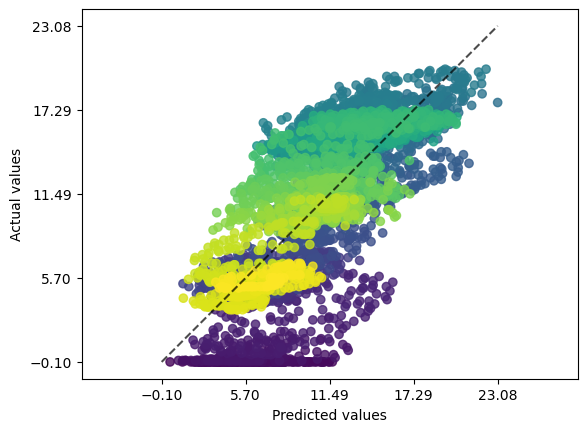

In [33]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import PredictionErrorDisplay
#X, y = load_diabetes(return_X_y=True)
data_t = df[26][2020].dropna()
p_data = F_plauborg(data_t)
ridge = LinearRegression().fit(p_data[15:], data_t.iloc[15:,[-1]])
y_pred = ridge.predict(p_data[15:])
display = PredictionErrorDisplay(y_true=data_t.iloc[15:,[-1]], y_pred=y_pred)
display.plot(kind = "actual_vs_predicted",scatter_kwargs = {
    "c": np.linspace(0,1,num = data_t.iloc[15:,[-1]].shape[0]),
    "color": None
})
plt.show()

In [17]:
print(df[22][2018].index)
df[22][2018].index.day_of_year*24 + df[22][2018].index.hour

DatetimeIndex(['2018-02-28 23:00:00+00:00', '2018-03-01 00:00:00+00:00',
               '2018-03-01 01:00:00+00:00', '2018-03-01 02:00:00+00:00',
               '2018-03-01 03:00:00+00:00', '2018-03-01 04:00:00+00:00',
               '2018-03-01 05:00:00+00:00', '2018-03-01 06:00:00+00:00',
               '2018-03-01 07:00:00+00:00', '2018-03-01 08:00:00+00:00',
               ...
               '2018-10-31 13:00:00+00:00', '2018-10-31 14:00:00+00:00',
               '2018-10-31 15:00:00+00:00', '2018-10-31 16:00:00+00:00',
               '2018-10-31 17:00:00+00:00', '2018-10-31 18:00:00+00:00',
               '2018-10-31 19:00:00+00:00', '2018-10-31 20:00:00+00:00',
               '2018-10-31 21:00:00+00:00', '2018-10-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=5880, freq=None)


Index([1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448,
       ...
       7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318],
      dtype='int32', name='Time', length=5880)